In [88]:
import numpy as np
import spaudiopy as spa
import matplotlib.pyplot as plt

import pandas as pd

from TS_TH_from_sphere_vector import TH_TS_wrapper
from TS_TH_from_beamforming import energy_from_beamforming

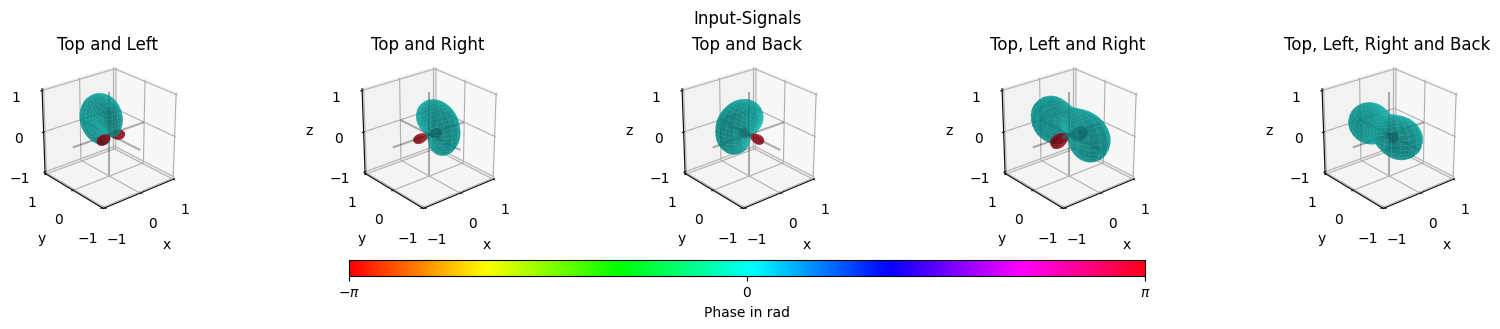

In [89]:
# INPUT - test directions

def test_input_signal(N, Omega):
    
    in_nm = spa.sph.sh_matrix(N, Omega[0], Omega[1]).conj()
    in_nm = spa.sph.repeat_per_order(spa.sph.hypercardioid_modal_weights(N)) * in_nm  # make cardioid

    #fig = plt.figure()
    #spa.plot.sh_coeffs(in_nm, title="Input", fig=fig)

    return(in_nm)

N_sph_in = 2
Omega_in = np.c_[[0,0],[0, np.pi/2],[np.pi/2,np.pi/2],[3*np.pi/2,np.pi/2],[np.pi, np.pi/2],[0,np.pi]] # ([top, front, left, right, back, bottom])

in_nm_top = test_input_signal(N_sph_in,Omega_in[:,0])
in_nm_front = test_input_signal(N_sph_in,Omega_in[:,1])
in_nm_left = test_input_signal(N_sph_in,Omega_in[:,2])
in_nm_right = test_input_signal(N_sph_in,Omega_in[:,3])
in_nm_back = test_input_signal(N_sph_in,Omega_in[:,4])
in_nm_bottom = test_input_signal(N_sph_in,Omega_in[:,5])

in_nm_single_directions = np.array([('top',in_nm_top), ('front',in_nm_front), ('left',in_nm_left),
                                     ('right', in_nm_right), ('back',in_nm_back), ('bottom',in_nm_bottom)],
                                     dtype = [('names','U10'),('data','f4',(1,(N_sph_in+1)**2))])
in_nm_top_to_direction = np.array([('t+l',in_nm_top+in_nm_left),
                                   ('t+r',in_nm_top+in_nm_right),
                                   ('t+b', in_nm_top+in_nm_back),
                                   ('t+l+r',in_nm_top+in_nm_left+in_nm_right),
                                   ('t+l+r+b',in_nm_top+in_nm_left+in_nm_right+in_nm_back)],
                                   dtype = [('names','U10'),('data','f4',(1,(N_sph_in+1)**2))])

spa.plot.sh_coeffs_subplot([in_nm_top+in_nm_left,
                           in_nm_top+in_nm_right,
                           in_nm_top+in_nm_back,
                           in_nm_top+in_nm_left+in_nm_right,
                           in_nm_top+in_nm_left+in_nm_right+in_nm_back],
                           titles=["Top and Left","Top and Right","Top and Back","Top, Left and Right","Top, Left, Right and Back"],
                           title="Input-Signals")



In [90]:
def method_wrapper(method, in_nm, i, N=2, start_milliseconds=15, stop_milliseconds=100, samplerate=44100):

    # use method
    match method:
        case "beamforming":
            # calc energy/direction with Beamforming
            energy = energy_from_beamforming(in_nm, N=1,start_milliseconds=start_milliseconds, stop_milliseconds=stop_milliseconds, samplerate=samplerate)
            
            # calc parameters
            TH = 10 * np.log10((np.sum(energy[0]**2) / np.sum((energy[2] + energy[3] + energy[4])**2)))
            TS = 10 * np.log10((np.sum(energy[0]**2) / np.sum((energy[2] + energy[3])**2)))
        
        case "pseudo_intensity":
            # insert pseudo intensity function here

            B_format = spa.sig.AmbiBSignal.sh_to_b(spa.sig.MultiSignal(in_nm[0:4].tolist(), fs = 44100))
            azimuth, zenith, radius = spa.parsa.pseudo_intensity(B_format, win_len = 3, f_bp = (63, 8000))
            elevation = zenith - (np.pi / 2)
            TH, TS = TH_TS_wrapper(azimuth, elevation, radius, start_milliseconds=start_milliseconds, stop_milliseconds=stop_milliseconds, samplerate=samplerate)
        
        case "reference":
            # insert reference
            
            weights = np.array(([500,-1,-1,720.1,-3.1,1.3,-1.3,-1.3,617.1],[503,0,723.1,0,-532.8,0,0,0,-311.2],[503,0,-723.1,0,-532.8,0,0,0,-311.2],[503,723.1,0,0,535.9,0,0,0,-305.8]))

            w_nm = [weights[:,0],weights[:,2],weights[:,3],weights[:,1],weights[:,8],weights[:,6],weights[:,4],weights[:,5],weights[:,7]]

            start_sample = int(start_milliseconds / 1000 * samplerate)
            stop_sample = int(stop_milliseconds /1000 * samplerate)
            ambi_3 = in_nm
            ambi_2 = ambi_3[[0,3,1,2,6,7,5,8,4]]
            ambi_2_sect = ambi_2[:,start_sample:stop_sample]
            w_nm = np.array(w_nm)
            y = spa.parsa.sh_beamform(w_nm.T, ambi_2_sect)
            TS = 10*np.log10(np.sum((y[0])**2)/np.sum((y[2] + y[1])**2))
            TH = 10*np.log10(np.sum((y[0])**2)/np.sum((y[1] + y[2] + y[3])**2))
        
        case 'ref2':
            in_nm_ones = np.ones(((N+1)**2,samplerate))
            start_sample = int(start_milliseconds / 1000 * samplerate)
            stop_sample = int(stop_milliseconds /1000 * samplerate)

            in_nm_top = (test_input_signal(N_sph_in,Omega_in[:,0])*in_nm_ones.T).T
            in_nm_left = (test_input_signal(N_sph_in,Omega_in[:,2])*in_nm_ones.T).T
            in_nm_right = (test_input_signal(N_sph_in,Omega_in[:,3])*in_nm_ones.T).T
            in_nm_back = (test_input_signal(N_sph_in,Omega_in[:,4])*in_nm_ones.T).T

            in_nm_top = in_nm_top[:,start_sample:stop_sample]
            in_nm_left = in_nm_left[:,start_sample:stop_sample]
            in_nm_right = in_nm_right[:,start_sample:stop_sample]
            in_nm_back = in_nm_back[:,start_sample:stop_sample]

            TS_1 = 10*np.log10((np.sum(in_nm_top[0,:]**2))/np.sum((in_nm_left[0,:])**2))
            TS_2 = 10*np.log10((np.sum(in_nm_top[0,:]**2))/np.sum((in_nm_left[0,:]+in_nm_right[0,:])**2))
            TH_1 = 10*np.log10((np.sum(in_nm_top[0,:]**2))/np.sum((in_nm_left[0,:]+in_nm_right[0,:]+in_nm_back[0,:])**2))
                        
            TS_test = [TS_1, TS_1, None, TS_2, TS_2]
            TH_test = [TS_1, TS_1, TS_1, TS_2, TH_1]
            TS = TS_test[i] 
            TH = TH_test[i]
        
        case _:
            methods = ["beamforming", "pseudo_intensity", "reference"]
            print("Unknown method. Methods are:")
            for m in methods:
               print(m)

            TH, TS = None, None
        
    return TH, TS

In [91]:
# Define input variables
#methods = ["beamforming", "pseudo_intensity", "reference","ref2"]
methods = ["beamforming", "reference","ref2"]
evaluation_start_ms = 15
evaluation_stop_ms = 100
sampling_freq = 44100

# create empty Dataframes to store results in
TH_results = pd.DataFrame()
TS_results = pd.DataFrame()
delta_results = pd.DataFrame()

i = 0
    
# iterate through signals and methods
for in_nm in in_nm_top_to_direction:
    in_nm_ones = np.ones(((N_sph_in+1)**2,sampling_freq*5))
    in_nm_sig = (np.array(in_nm['data'][0,:])*in_nm_ones.T).T
    for method in methods:
        try:
            TH, TS = method_wrapper(method, in_nm_sig, i, start_milliseconds = evaluation_start_ms, stop_milliseconds=evaluation_stop_ms, samplerate=sampling_freq)
            print(method, "TS:", TS, "TH:", TH)
        except:
            print(method, "not working")
            TH = None
            TS = None

        # save data
        TH_results.loc[in_nm['names'], method] = TH
        TS_results.loc[in_nm['names'], method] = TS

        try:
            delta_results.loc[in_nm['names'], method] = TS - TH

        except:
            delta_results.loc[in_nm['names'], method] = None

    i = i+1
    print("")

beamforming TS: 1.9381999733438153 TH: -1.583625207769809
reference TS: 6.960047435891995 TH: -0.8452118807077373
ref2 TS: 0.0 TH: 0.0

beamforming TS: 1.9381999733438153 TH: -1.583625207769809
reference TS: -9.547818651612596 TH: -17.35307796821233
ref2 TS: 0.0 TH: 0.0

beamforming TS: 1.938199973343814 TH: -5.105450229540485
reference TS: 2.1843356169359183 TH: -5.620923699663814
ref2 TS: None TH: 0.0

beamforming TS: -1.994551917598995e-08 TH: -3.521825201059146
reference TS: -6.111832715161778 TH: -11.755172111502892
ref2 TS: -6.020599913279624 TH: -6.020599913279624

beamforming TS: -1.1598391444232445 TH: -6.61986449009223
reference TS: -11.149465390822238 TH: -16.07981705377953
ref2 TS: -6.020599913279624 TH: -9.542425094393248



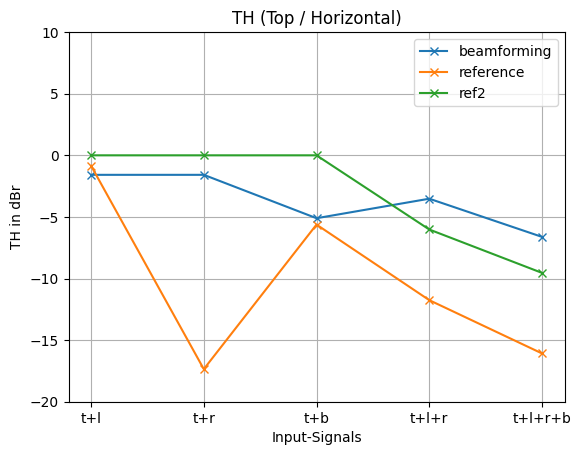

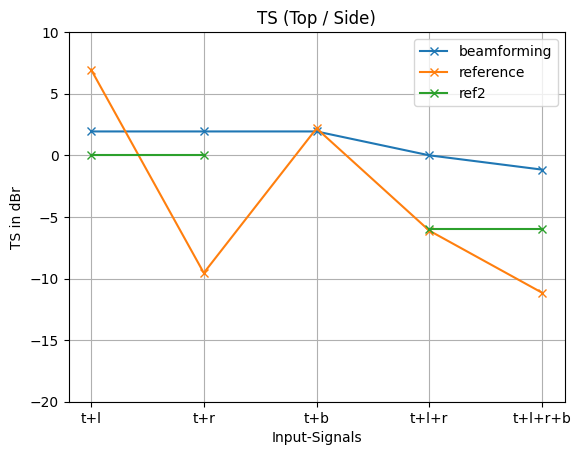

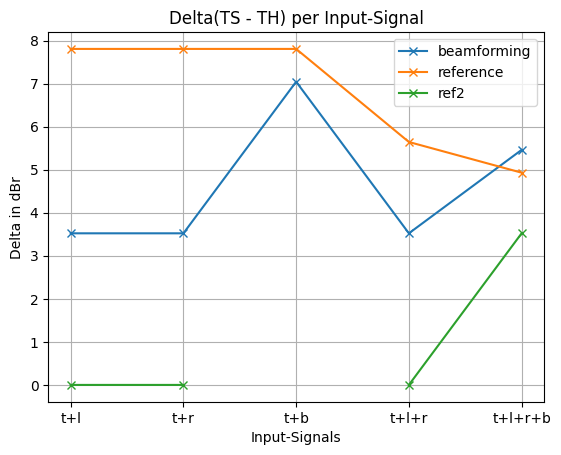

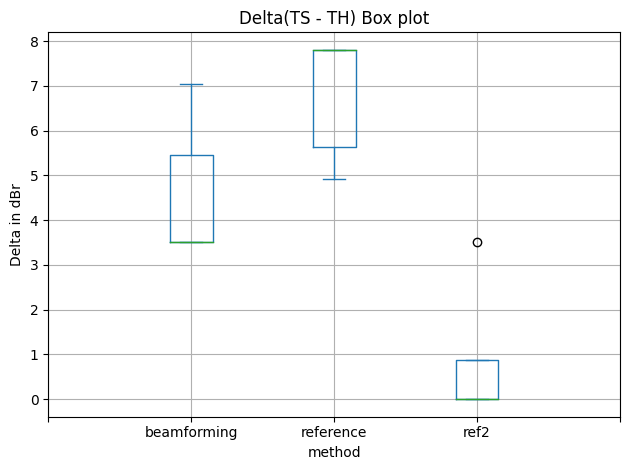

In [92]:
#TH_results.plot()
plt.plot(TH_results, marker='x')
plt.title('TH (Top / Horizontal)')
plt.xlabel('Input-Signals')
plt.ylabel('TH in dBr')
plt.ylim([-20,10])
plt.grid()
plt.xticks([0,1,2,3,4])
plt.legend(TH_results.columns)
#plt.savefig('../out/TH.png')
plt.show()


#TS_results.plot()
plt.plot(TS_results, marker='x')
plt.title('TS (Top / Side)')
plt.xlabel('Input-Signals')
plt.ylabel('TS in dBr')
plt.ylim([-20,10])
plt.grid()
plt.xticks([0,1,2,3,4])
plt.legend(TS_results.columns)
#plt.savefig('../out/TS.png')
plt.show()


#delta_results.plot()
plt.plot(delta_results, marker='x')
plt.title('Delta(TS - TH) per Input-Signal')
plt.xlabel('Input-Signals')
plt.ylabel('Delta in dBr')
plt.grid()
plt.xticks([0,1,2,3,4])
plt.legend(delta_results.columns)
#plt.savefig('../out/Delta.png')
plt.show()


delta_results.plot(kind='box')
plt.title('Delta(TS - TH) Box plot')
plt.xlabel('method')
plt.ylabel('Delta in dBr')
plt.grid()
plt.tight_layout()
plt.xticks([0,1,2,3,4])
#plt.savefig('../out/Delta_boxplot.png')
plt.show()
